In [ ]:
# Amitabh S Mishra

In [ ]:
# Download Dataset
!apt install subversion
!svn export https://github.com/pransin/gcn/trunk/data/cora

Reading package lists... Done
Building dependency tree       
Reading state information... Done
subversion is already the newest version (1.9.7-4ubuntu1.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
svn: E155000: Destination directory exists; please remove the directory or use --force to overwrite
svn: E155000: 'cora' already exists


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.nn.parameter import Parameter
from tqdm.notebook import tqdm
from scipy.linalg import sqrtm 
import scipy.sparse as sp


In [ ]:
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
# Open dataset
data_dir = os.path.join('.', "cora")
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"),
    sep="\t",
    header=None,
    names=["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"],
)

print(papers.subject.value_counts())

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: subject, dtype: int64


In [ ]:
citations
#papers

,target,source
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960
...,...,...
5424,853116,19621
5425,853116,853155
5426,853118,1140289
5427,853155,853118


## Train test split


In [ ]:
node_id = papers["paper_id"].to_numpy()
#node_id
temp_d = dict(enumerate(node_id))
id_node = {v: k for k, v in temp_d.items()}
 #id_node  # Now we have paper_id to node index mapping

In [ ]:
id_subjects = papers[['subject']]
print(id_subjects)
id_subjects.insert(loc=0,column='nodes',value=range(0,len(id_subjects)))
node_sub = id_subjects
classes = node_sub['subject'].unique()
sub_indices = {}
for label in classes:
  sub_indices[label] = node_sub.loc[node_sub.subject==label,'nodes'].values

                     subject
0            Neural_Networks
1              Rule_Learning
2     Reinforcement_Learning
3     Reinforcement_Learning
4      Probabilistic_Methods
...                      ...
2703      Genetic_Algorithms
2704      Genetic_Algorithms
2705      Genetic_Algorithms
2706              Case_Based
2707         Neural_Networks

[2708 rows x 1 columns]


In [ ]:
train_indices = {}
for l in classes:
  train_indices[l] = np.random.choice(sub_indices[l],size=15, replace=False)
# len(train_indices)
train_indices

{'Neural_Networks': array([ 263, 1373, 2631, 1612, 2671, 1751, 1947, 2540,  589, 1766,  207,
        1246, 2247,  625, 1606]),
 'Rule_Learning': array([ 196, 2240, 1596,  417, 2070, 2009, 1881, 1963, 1256, 1578, 2539,
        1180, 2300, 1620, 2441]),
 'Reinforcement_Learning': array([1616,  410,  738,  551, 2408,   21,  425, 1589,  882, 2494,  565,
         621,  492,  466,   16]),
 'Probabilistic_Methods': array([ 161,  646, 2366, 1503, 1241,  704, 1759, 2348, 1995, 1133,  584,
         108, 2693, 2428,    4]),
 'Theory': array([ 555, 2342,  114,  859, 1173, 1647, 1199, 1521, 2346, 2080, 1280,
         251,   89,  887, 1833]),
 'Genetic_Algorithms': array([ 728,  934, 1880, 2521, 1333, 1311,  422,  856, 1404, 2130,  972,
         546, 1740, 2563, 1216]),
 'Case_Based': array([1989,  818,  951, 2289,  670,  983,  984,  285,  690, 1348,  947,
        1531,  679, 1805,  634])}

In [ ]:
# train_arr = np.empty((1,))
train_arr = np.concatenate([train_indices[l] for l in classes],axis=0)
train_arr.shape
train_arr

array([ 263, 1373, 2631, 1612, 2671, 1751, 1947, 2540,  589, 1766,  207,
       1246, 2247,  625, 1606,  196, 2240, 1596,  417, 2070, 2009, 1881,
       1963, 1256, 1578, 2539, 1180, 2300, 1620, 2441, 1616,  410,  738,
        551, 2408,   21,  425, 1589,  882, 2494,  565,  621,  492,  466,
         16,  161,  646, 2366, 1503, 1241,  704, 1759, 2348, 1995, 1133,
        584,  108, 2693, 2428,    4,  555, 2342,  114,  859, 1173, 1647,
       1199, 1521, 2346, 2080, 1280,  251,   89,  887, 1833,  728,  934,
       1880, 2521, 1333, 1311,  422,  856, 1404, 2130,  972,  546, 1740,
       2563, 1216, 1989,  818,  951, 2289,  670,  983,  984,  285,  690,
       1348,  947, 1531,  679, 1805,  634])

In [ ]:
excl_train = []  #This will have all indices except the ones already selected in training set

for ele in range(2708):
  if ele not in train_arr:
    excl_train.append(ele)

In [ ]:
# Now choose random 1000 from excl_train for test
rand_arr = np.random.choice(np.array(excl_train),size=1535, replace=False)
val_arr = rand_arr[:1535]
# test_arr = rand_arr[500:1500]

### Getting A_hat

In [ ]:
# For full adjacency matrix:
At = np.eye(papers.shape[0], dtype=float)  #At is A~ here self loop
for ind in citations.index: 
  i = id_node[citations['target'][ind]]
  j = id_node[citations['source'][ind]]
  At[i][j] = At[j][i] = 1

In [ ]:
n1 = id_node[35]
n2 = id_node[1033]
# A[n1][n2], A[n2][n1]
At.shape

(2708, 2708)

In [ ]:
# now get A hat
D = np.zeros_like(At)
np.fill_diagonal(D, np.asarray(At.sum(axis=1)).flatten())

D_invroot = np.linalg.inv(sqrtm(D))

A_hat = D_invroot @ At @ D_invroot
# A_hat

## Getting H

In [ ]:
H = papers.loc[:, ~papers.columns.isin(['paper_id', 'subject'])].to_numpy()

"""Row-normalize sparse matrix"""
rowsum = np.sum(H,axis=1)
rowsum = rowsum.astype(float)
r_inv = np.power(rowsum, -1).flatten()
r_inv[np.isinf(r_inv)] = 0.
r_mat_inv = sp.diags(r_inv)
H = r_mat_inv.dot(H)

np.sum(H) #ans should be 2708
# np.sum(H,axis=0)
# np.sum(H,axis=1).shape

2707.9999999999995

In [ ]:
A_hat.shape, H.shape

((2708, 2708), (2708, 1433))

In [ ]:
H = torch.FloatTensor(H)
A_hat = torch.FloatTensor(A_hat)

## Get labels for each node

In [ ]:
labels = papers["subject"]
classes = set(labels)
classes = {label: idx for idx, label in enumerate(classes)}
labels = [classes[label] for label in labels]
labels = torch.LongTensor(labels)
labels

tensor([3, 0, 4,  ..., 2, 1, 3])

## GCN Layer

In [ ]:
class GCNLayer(nn.Module):
  def __init__(self, in_features, out_features):
    super().__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.weight = Parameter(torch.FloatTensor(in_features, out_features))
    self.register_parameter('bias', None)
    nn.init.xavier_uniform_(self.weight)
    # self.layer = nn.Linear(in_features, out_features)

  
  def forward(self, H, A_hat):
      tes = (A_hat @ H)
      return tes @ self.weight 
  

    

In [ ]:
class GCN(nn.Module):
  def __init__(self, nfeat, nhid, nclass, dropout=0):
    super().__init__()
    self.gc1 = GCNLayer(nfeat, nhid)
    self.gc2 = GCNLayer(nhid, nclass)
    self.dropout = dropout
    # Model goes here
  
  def forward(self, x, A_hat):
    x = F.relu(self.gc1(x, A_hat))
    x = F.dropout(x, self.dropout, training=self.training)
    x = self.gc2(x, A_hat)
    return x

In [ ]:
dropout = 0.5
regularization = 0.0005
learning_rate = 0.01
early_stop_window = 10
nhid = 16
total_epochs = 200
nclass = 7

In [ ]:
# Random train-test split
idx_train = train_arr
idx_val = val_arr
# idx_test = test_arr

In [ ]:
model = GCN(nfeat=H.shape[1],
            nhid=nhid,
            nclass=nclass,
            dropout=dropout)
loss_criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=regularization)

In [ ]:
def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

def evaluate(idx_val=idx_val):
      model.eval()
      prediction = model(H, A_hat)                          
      loss_eval = loss_criterion(prediction[idx_val], labels[idx_val])                          
      acc = accuracy(prediction[idx_val], labels[idx_val])
      return loss_eval.item(), acc

def train_step():
      model.train()
      prediction = model(H, A_hat)                          
      loss = loss_criterion(prediction[idx_train], labels[idx_train])                               
      acc = accuracy(prediction[idx_train], labels[idx_train])
      return loss, acc

In [ ]:
# Put the model into training mode. This activates the dropout and batchnorm layers for training

acc_train = []
acc_val = []
loss_train = []
loss_val = []
no_improve = 0
best_loss = 100
for epoch in tqdm(range(1,total_epochs+1)):

      loss, acc_t = train_step()
      loss_eval, acc_eval = evaluate()
      acc_train.append(acc_t)
      acc_val.append(acc_eval)
      loss_train.append(loss.item())
      loss_val.append(loss_eval)

      if(loss_eval < best_loss):
        no_improve = 0
        best_loss = loss_eval
      else:
        no_improve += 1

      if no_improve == early_stop_window:
        break

      # 3. zero out the gradients and perform backpropagation through the network
      optimizer.zero_grad()
      loss.backward()

      # 4. update the parameters
      optimizer.step()

      print(f"Epoch: [{epoch}/{total_epochs}] Train Loss: {loss.item():.4f}, Train Accuracy: {acc_t:.4f}, Validation Loss: {loss_eval:.4f}")

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: [1/200] Train Loss: 1.9453, Train Accuracy: 0.1714, Validation Loss: 1.9457
Epoch: [2/200] Train Loss: 1.9393, Train Accuracy: 0.3810, Validation Loss: 1.9429
Epoch: [3/200] Train Loss: 1.9316, Train Accuracy: 0.4857, Validation Loss: 1.9396
Epoch: [4/200] Train Loss: 1.9222, Train Accuracy: 0.4667, Validation Loss: 1.9356
Epoch: [5/200] Train Loss: 1.9122, Train Accuracy: 0.4762, Validation Loss: 1.9312
Epoch: [6/200] Train Loss: 1.9031, Train Accuracy: 0.5429, Validation Loss: 1.9267
Epoch: [7/200] Train Loss: 1.8926, Train Accuracy: 0.5714, Validation Loss: 1.9217
Epoch: [8/200] Train Loss: 1.8796, Train Accuracy: 0.5810, Validation Loss: 1.9165
Epoch: [9/200] Train Loss: 1.8683, Train Accuracy: 0.5714, Validation Loss: 1.9112
Epoch: [10/200] Train Loss: 1.8584, Train Accuracy: 0.5810, Validation Loss: 1.9056
Epoch: [11/200] Train Loss: 1.8469, Train Accuracy: 0.6000, Validation Loss: 1.9000
Epoch: [12/200] Train Loss: 1.8359, Train Accuracy: 0.6476, Validation Loss: 1.8942
E

In [ ]:
loss_eval, acc = evaluate(idx_val)
print(f'Test Loss = {loss_eval}')
print(f'Test Accuracy = {acc}')

Test Loss = 0.8809847235679626
Test Accuracy = 0.7863192182410423


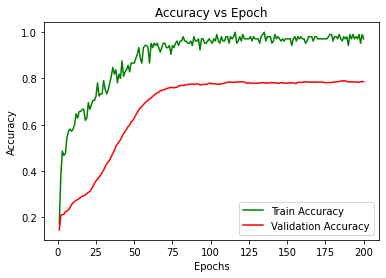

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1,len(acc_train) + 1), acc_train, 'g', label='Train Accuracy')
plt.plot(range(1,len(acc_val) + 1), acc_val, 'r', label='Validation Accuracy')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
len(loss_train)

200

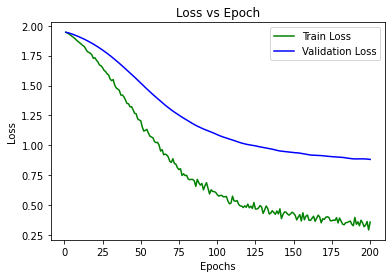

In [ ]:
plt.plot(range(1,len(loss_train) + 1), loss_train, 'g', label='Train Loss')
plt.plot(range(1,len(loss_val) + 1), loss_val, 'b', label='Validation Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()